In [1]:
import os
import cv2
from tqdm import tqdm
import albumentations as A
from PIL import Image
import numpy as np
from pathlib import Path

input_dir = Path("/kaggle/input/fishes-img/Fishes")
output_dir = Path("/kaggle/working/augmented")
output_dir.mkdir(exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomCrop(width=200, height=200, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
])

for cls in os.listdir(input_dir):
    cls_path = input_dir / cls
    if not cls_path.is_dir():
        continue
    
    (output_dir / cls).mkdir(exist_ok=True)

    images = list(cls_path.glob("*.*"))
    
    for img_path in tqdm(images, desc=f"Augmenting {cls}"):
        img = cv2.imread(str(img_path))[:,:,::-1]
        
        # 5 augmentations per image
        for i in range(10):
            aug = transform(image=img)['image']
            aug = cv2.cvtColor(aug, cv2.COLOR_RGB2BGR)

            save_name = f"{img_path.stem}_aug_{i}.jpg"
            cv2.imwrite(str(output_dir/cls/save_name), aug)

print("DONE!")

Augmenting Croaker(Poya): 100%|██████████| 11/11 [00:27<00:00,  2.51s/it]

DONE!


In [2]:
aug_count = sum(len(files) for _,_,files in os.walk(output_dir))
print("TOTAL AUGMENTED IMAGES =", aug_count)

TOTAL AUGMENTED IMAGES = 5830


In [15]:
# =======================
# STEP 1: IMPORTS & CONFIG
# =======================
import os
import random
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# -------- Config class --------
class CFG:
    # ⬇️ EI PATH TA CHANGE KORTE HOBE
    DATA_DIR = "/kaggle/working/augmented"  # Fishes folder er absolute path

    BATCH_SIZE = 16
    NUM_WORKERS = 2
    EPOCHS = 5            # SimCLR training epochs
    LR = 1e-3
    TEMPERATURE = 0.5       # SimCLR temperature
    FEATURE_DIM = 128        # projection head er output size
    IMAGE_SIZE = 224
    SEED = 42
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LINEAR_EPOCHS = 10
    MAX_TSNE_POINTS = 1500   # t-SNE-er jonno maximum sample
    PRINT_FREQ = 50

cfg = CFG()

# -------- Reproducibility --------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)

print("Device:", cfg.DEVICE)
print("Data dir:", cfg.DATA_DIR)


Device: cuda
Data dir: /kaggle/working/augmented


In [16]:
# =======================
# STEP 2: DATA & AUGMENTATIONS
# =======================
# Gaussian blur for SimCLR
class GaussianBlur(object):
    def __init__(self, kernel_size=23, sigma=(0.1, 2.0)):
        self.blur = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)

    def __call__(self, x):
        return self.blur(x)

# SimCLR style transform (duita view)
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(cfg.IMAGE_SIZE, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    GaussianBlur(kernel_size=23),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Normal eval transform
eval_transform = transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Dataset: 2 ta augmented view + ekta clean view
class SimCLRDataset(Dataset):
    def __init__(self, root, transform=None, eval_transform=None):
        self.dataset = ImageFolder(root=root)
        self.transform = transform
        self.eval_transform = eval_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if self.transform is not None:
            xi = self.transform(img)
            xj = self.transform(img)
        else:
            xi = xj = img

        if self.eval_transform is not None:
            x_clean = self.eval_transform(img)
        else:
            x_clean = None

        return xi, xj, x_clean, label

# SimCLR training dataset
simclr_dataset = SimCLRDataset(
    root=cfg.DATA_DIR,
    transform=simclr_transform,
    eval_transform=eval_transform
)

num_classes = len(simclr_dataset.dataset.classes)
print("Number of classes:", num_classes)
print("Classes:", simclr_dataset.dataset.classes)

simclr_loader = DataLoader(
    simclr_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

# Evaluation dataset (clean images only)
eval_dataset = ImageFolder(
    root=cfg.DATA_DIR,
    transform=eval_transform
)
eval_loader = DataLoader(
    eval_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)


Number of classes: 21
Classes: ['Baim', 'Bata', 'Batasio(tenra)', 'Chitul', 'Croaker(Poya)', 'Hilsha', 'Kajoli', 'Meni', 'Pabda', 'Poli', 'Puti', 'Rita', 'Rui', 'Rupchada', 'Silver Carp', 'Telapiya', 'carp', 'k', 'kaikka', 'koral', 'shrimp']


In [18]:
# =======================
# STEP 3: MODEL (RESNET50 + PROJECTION HEAD)
# =======================
class ResNet50Encoder(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        # Different torchvision version handle:
        try:
            backbone = resnet50(weights=None if not pretrained else 'IMAGENET1K_V1')
        except TypeError:
            backbone = resnet50(pretrained=pretrained)
        backbone.fc = nn.Identity()     # classification head remove
        self.backbone = backbone
        self.out_dim = 2048

    def forward(self, x):
        return self.backbone(x)

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        x = self.net(x)
        x = F.normalize(x, dim=1)
        return x

class SimCLR(nn.Module):
    def __init__(self, temperature=0.5, feature_dim=128, pretrained_backbone=False):
        super().__init__()
        self.temperature = temperature
        self.encoder = ResNet50Encoder(pretrained=pretrained_backbone)
        self.projector = ProjectionHead(self.encoder.out_dim, feature_dim)

    def forward(self, xi, xj):
        hi = self.encoder(xi)
        hj = self.encoder(xj)
        zi = self.projector(hi)
        zj = self.projector(hj)
        return hi, hj, zi, zj


In [19]:
# =======================
# STEP 4: NT-Xent LOSS
# =======================
def nt_xent_loss(zi, zj, temperature):
    """
    zi, zj : [N, D]
    """
    N = zi.size(0)
    z = torch.cat([zi, zj], dim=0)         # [2N, D]
    z = F.normalize(z, dim=1)

    # cosine similarity matrix
    sim = torch.matmul(z, z.T)             # [2N, 2N]
    sim = sim / temperature

    # self-similarity mask
    mask = torch.eye(2 * N, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -1e9)

    # positive indices: for i in [0..N-1] -> i+N, for i in [N..2N-1] -> i-N
    labels = torch.cat([
        torch.arange(N, 2 * N),
        torch.arange(0, N)
    ]).to(z.device)

    loss = F.cross_entropy(sim, labels)
    return loss


In [21]:
import gc, torch

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")


CUDA cache cleared.


In [22]:
# =======================
# STEP 5: TRAINING LOOP (5 EPOCHS)
# =======================
def train_simclr(model, dataloader, epochs, lr, temperature):
    model.to(cfg.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    loss_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        n_batches = 0
        t0 = time.time()

        for step, (xi, xj, _, _) in enumerate(dataloader):
            xi = xi.to(cfg.DEVICE, non_blocking=True)
            xj = xj.to(cfg.DEVICE, non_blocking=True)

            optimizer.zero_grad()
            _, _, zi, zj = model(xi, xj)
            loss = nt_xent_loss(zi, zj, temperature)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

            if (step + 1) % cfg.PRINT_FREQ == 0:
                print(
                    f"Epoch [{epoch}/{epochs}] Step [{step+1}/{len(dataloader)}] "
                    f"Loss: {loss.item():.4f}"
                )

        scheduler.step()
        avg_loss = epoch_loss / n_batches
        loss_history.append(avg_loss)
        print(
            f"Epoch [{epoch}/{epochs}] Avg Loss: {avg_loss:.4f} "
            f"| Time: {time.time()-t0:.1f}s"
        )

    return model, loss_history


# -------- SimCLR model create + 5 epoch train --------
simclr_model = SimCLR(
    temperature=cfg.TEMPERATURE,
    feature_dim=cfg.FEATURE_DIM,
    pretrained_backbone=False  # chaile True dile ImageNet init use korte paren
)

simclr_model, loss_history = train_simclr(
    simclr_model,
    simclr_loader,
    epochs=5,                # <-- ekhane 5 epoch
    lr=cfg.LR,
    temperature=cfg.TEMPERATURE
)


Epoch [1/5] Step [50/91] Loss: 4.3631
Epoch [1/5] Avg Loss: 4.4614 | Time: 654.7s
Epoch [2/5] Step [50/91] Loss: 4.2716
Epoch [2/5] Avg Loss: 4.1526 | Time: 622.7s
Epoch [3/5] Step [50/91] Loss: 3.7142
Epoch [3/5] Avg Loss: 3.9412 | Time: 610.8s
Epoch [4/5] Step [50/91] Loss: 3.7264
Epoch [4/5] Avg Loss: 3.7995 | Time: 644.9s
Epoch [5/5] Step [50/91] Loss: 3.6444
Epoch [5/5] Avg Loss: 3.6981 | Time: 633.1s


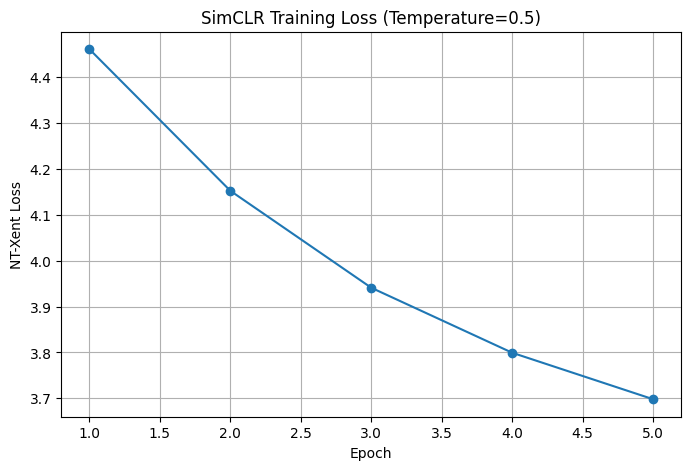

In [23]:
# =======================
# STEP 6: LOSS CURVE VISUALIZATION
# =======================
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("NT-Xent Loss")
plt.title(f"SimCLR Training Loss (Temperature={cfg.TEMPERATURE})")
plt.grid(True)
plt.show()


In [24]:
# =======================
# STEP 7: FEATURE EXTRACTION (BACKBONE THEKE)
# =======================
def extract_features(backbone, dataloader, max_samples=None):
    backbone.to(cfg.DEVICE)
    backbone.eval()

    feats_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(cfg.DEVICE, non_blocking=True)
            feats = backbone(imgs)
            feats = feats.view(feats.size(0), -1)

            feats_list.append(feats.cpu())
            labels_list.append(labels.cpu())

            if max_samples is not None:
                if sum(len(x) for x in labels_list) >= max_samples:
                    break

    features = torch.cat(feats_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    if max_samples is not None and len(labels) > max_samples:
        features = features[:max_samples]
        labels = labels[:max_samples]

    return features.numpy(), labels.numpy()

backbone = simclr_model.encoder

# t-SNE er jonno subset feature
tsne_features, tsne_labels = extract_features(
    backbone,
    eval_loader,
    max_samples=cfg.MAX_TSNE_POINTS
)

print("t-SNE features shape:", tsne_features.shape)


t-SNE features shape: (1500, 2048)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.003s...
[t-SNE] Computed neighbors for 1500 samples in 0.380s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 4.924524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.280407
[t-SNE] KL divergence after 1000 iterations: 0.473727


/tmp/ipykernel_47/1553261517.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


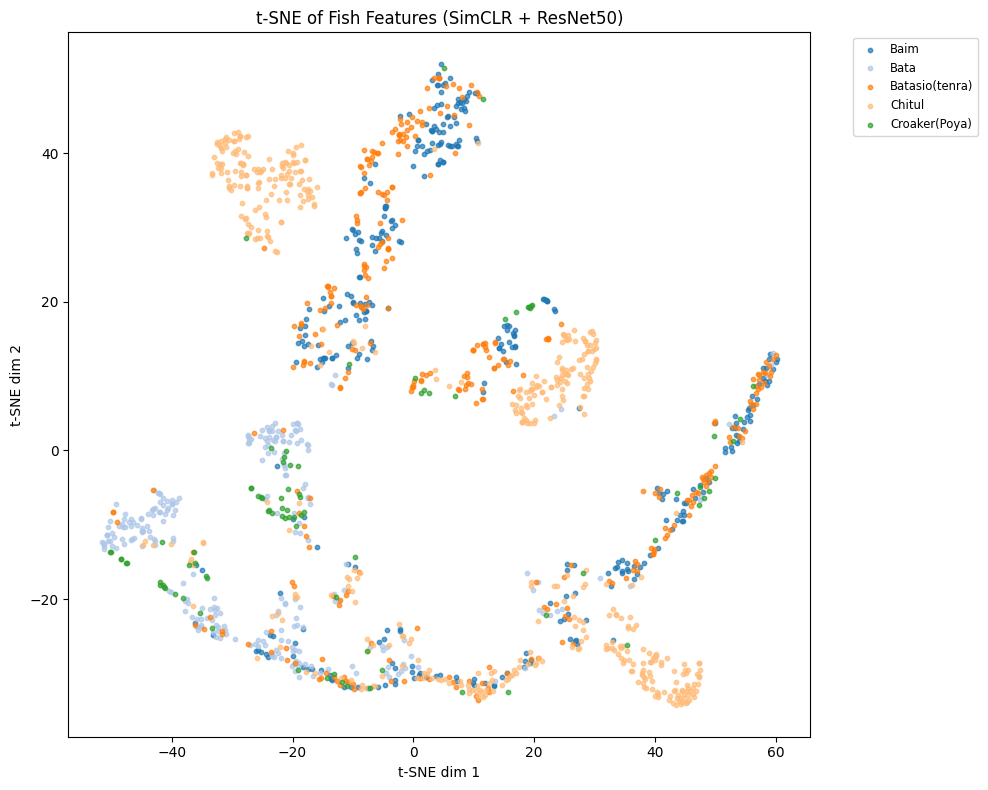

In [25]:
# =======================
# STEP 8: t-SNE VISUALIZATION
# =======================
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    verbose=1,
    random_state=cfg.SEED
)

tsne_results = tsne.fit_transform(tsne_features)

plt.figure(figsize=(10, 8))

num_classes = len(eval_dataset.classes)
colors = plt.cm.get_cmap('tab20', num_classes)

for class_id in range(num_classes):
    idx = tsne_labels == class_id
    if np.sum(idx) == 0:
        continue
    plt.scatter(
        tsne_results[idx, 0],
        tsne_results[idx, 1],
        s=10,
        alpha=0.7,
        label=eval_dataset.classes[class_id],
        c=[colors(class_id)]
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("t-SNE of Fish Features (SimCLR + ResNet50)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()


All features: (5830, 2048) labels: (5830,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Evaluation Accuracy: 49.49%
Classification report:
                precision    recall  f1-score   support

          Baim       0.32      0.28      0.30        68
          Bata       0.39      0.63      0.49        52
Batasio(tenra)       0.50      0.50      0.50        64
        Chitul       0.81      0.91      0.86        98
 Croaker(Poya)       0.67      0.36      0.47        22
        Hilsha       0.57      0.39      0.46        54
        Kajoli       0.37      0.47      0.41        96
          Meni       0.47      0.45      0.46        62
         Pabda       0.44      0.43      0.43        86
          Poli       0.64      0.53      0.58        34
          Puti       0.52      0.43      0.47        56
          Rita       0.50      0.38      0.43        26
           Rui       0.52      0.42      0.46        38
      Rupchada       0.62      0.50      0.55        32
   Silver Carp       0.48      0.46      0.47        28
      Telapiya       0.45      0.57      0.50

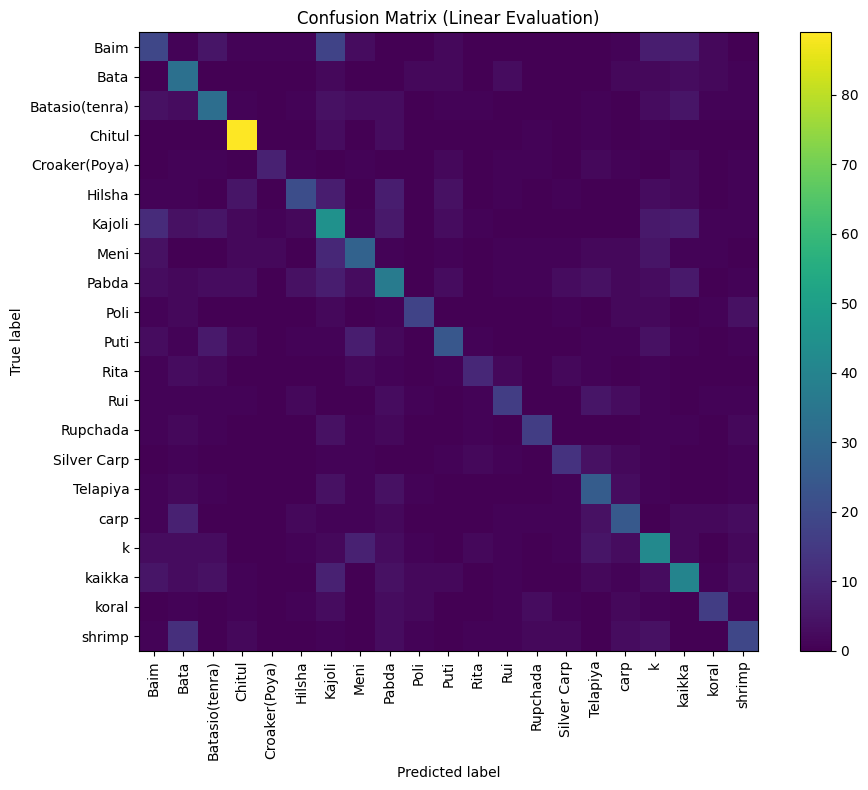

In [26]:
# =======================
# STEP 9: LINEAR EVALUATION (LOGISTIC REGRESSION)
# =======================
all_features, all_labels = extract_features(backbone, eval_loader, max_samples=None)
print("All features:", all_features.shape, "labels:", all_labels.shape)

X_train, X_val, y_train, y_val = train_test_split(
    all_features,
    all_labels,
    test_size=0.2,
    random_state=cfg.SEED,
    stratify=all_labels
)

linear_clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    verbose=1
)
linear_clf.fit(X_train, y_train)

y_pred = linear_clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Linear Evaluation Accuracy: {acc*100:.2f}%")

print("Classification report:")
print(classification_report(y_val, y_pred, target_names=eval_dataset.classes))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(eval_dataset.classes, rotation=90)
ax.set_yticklabels(eval_dataset.classes)

ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title("Confusion Matrix (Linear Evaluation)")
plt.tight_layout()
plt.show()
